In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

from src.helpers import get_FD_matrix, calculate_relgap, plot_eigenvalues, spectral_scale
from src.experiments import approximation_convergence, get_bound_taylor, get_bound_chebyshev

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Read/build the matrices

In [3]:
# orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
# bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
# gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
# helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

In [4]:
def get_test_matrices(n: int, a: float, b: float):
    # Check the shape of the 2D Laplace matrix
    assert (n ** .5) % 1 == 0

    # 1D Laplace stiffness matrix
    A1 = spectral_scale(A=get_FD_matrix(n=n, d=1, scale=False), a=a, b=b)
    # 2D Laplace stiffness matrix
    A2 = spectral_scale(A=get_FD_matrix(n=(n ** .5), d=2, scale=False), a=a, b=b)
    # Diagonal uniformly distributed eigenvalues
    A3 = sps.diags(np.linspace(a, b, n))
    # Diagonal geometrically distributed eigenvalues
    A4 = sps.diags(+np.geomspace(a, b or (b-1e-10), n))
    # Diagonal reversed geometrically distributed eigenvalues
    A5 = sps.diags(-np.geomspace(a, b or (b-1e-10), n) + b + a)

    return A1, A2, A3, A4, A5


## Analyze the matrices

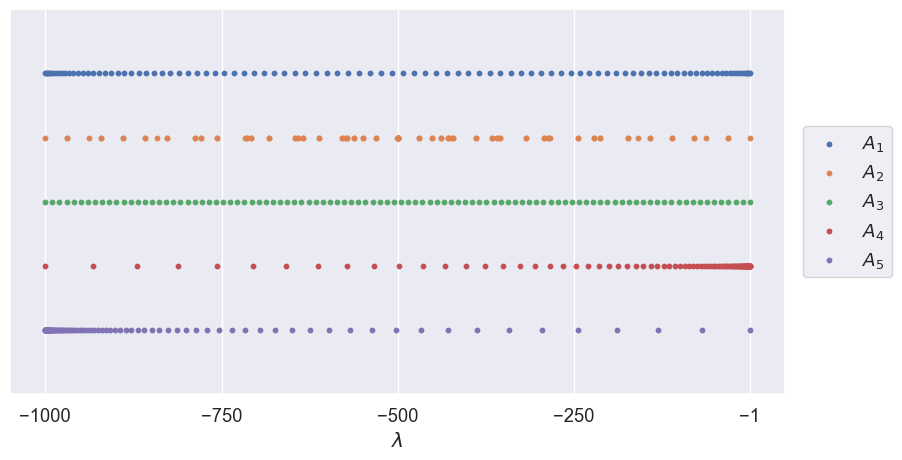

In [8]:
# Eigenvalue distribution

plot_eigenvalues(
    As=[*get_test_matrices(n=100, a=-1000, b=-1)],
    legends=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$'],\
    xticks=[-1000, -750, -500, -250, -1]
    # range_=(-1000, 0),
)

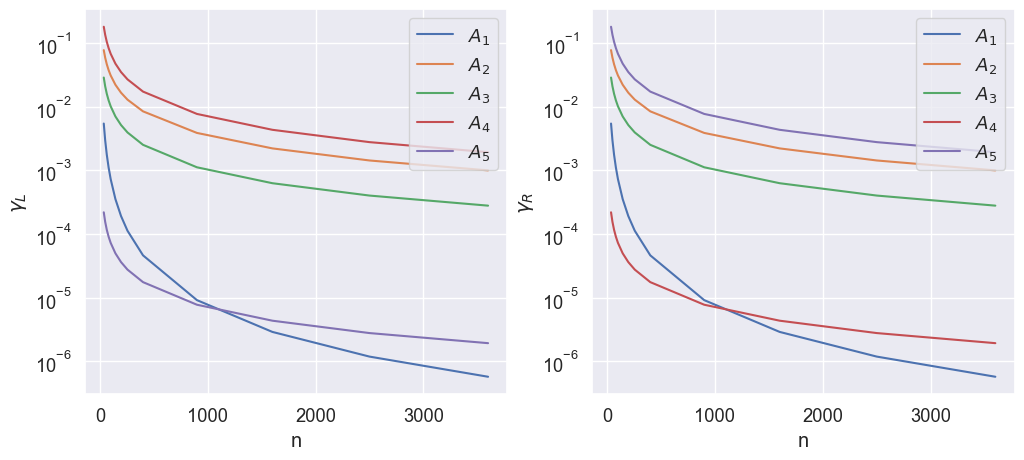

In [56]:
# Relative gap

names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
data = {'n': [], 'Matrix': [], 'g_l': [], 'g_r': []}
a, b = -1000, -1
for n in [n ** 2 for n in [6, 7, 8, 9, 10, 12, 14, 16, 20, 30, 40, 50, 60]]:
    I = sps.identity(n=n)
    for idx, A in enumerate(get_test_matrices(n=n, a=a, b=b)):
        data['n'].append(n)
        data['Matrix'].append(names[idx])
        g_l, g_r = calculate_relgap(A, lam_min1=a, lam_max1=b)
        data['g_l'].append(g_l)
        data['g_r'].append(g_r)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_l', hue='Matrix', ax=axs[0])
axs[0].set(yscale='log', ylabel='$\gamma_L$', xlabel='n')
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_r', hue='Matrix', ax=axs[1])
axs[1].set(yscale='log', ylabel='$\gamma_R$', xlabel='n')
for ax in axs:
    ax.legend()

## Problem for matrices with large values

In [3]:
# from src.phi import Phi

<Axes: >

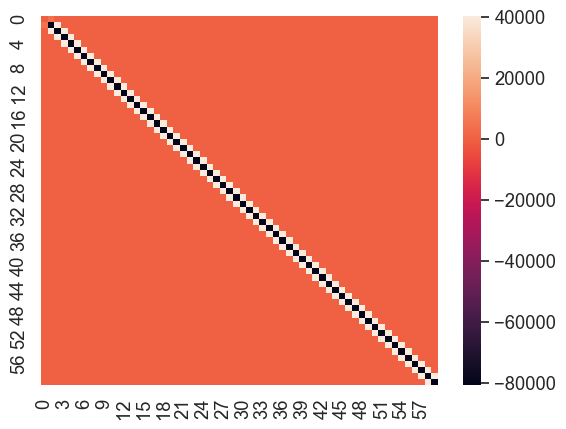

In [4]:
# A = get_FD_matrix(n=200, d=1)
# v = np.ones(shape=A.shape[0], dtype=A.dtype)
# V_m, H_m = Phi.standardarnoldi(A=A, v=v, m=60)
# sns.heatmap(pd.DataFrame(H_m))

When trying to calculate the $\exp(\hat{H}_m)$, overflow happens in `scipy.linalg.expm()`. Somewhere in their algorithm, they compute $\cosh(0.5 \sqrt{(a_1-a_4)^2 + 4 a_2 a_3})$ for $2 \times 2$ submatrices. The largest representable value by `float64` is $2^{1024} \simeq e^{700}$.

> Suddenly solved by itself !!

# Convergence results for $\varphi(A)v$

## Run the experiments

In [ ]:
ns = [
    (400, 300, [int(m) for m in np.linspace(5, 250, 30)]),
    (900, 500, [int(m) for m in np.linspace(5, 400, 30)]),
    (1600, 600, [int(m) for m in np.linspace(5, 500, 30)]),
    (2500, 700, [int(m) for m in np.linspace(5, 600, 30)]),
    (3600, 800, [int(m) for m in np.linspace(5, 700, 30)]),
    (4900, 900, [int(m) for m in np.linspace(5, 800, 30)]),
]
b = -1

ds = []
for n, m_exact, ms in ns:
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    for a in [-a for a in [1000, 5000, 10000]]:
        names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
        for name, A in zip(names, get_test_matrices(n=n, a=a, b=b)):
            d = approximation_convergence(
                A=A,
                v=v,
                m_exact=m_exact,
                ps=range(4),
                ms=ms,
            )
            d['name'] = [name] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

            # NOTE: Error because of large factorials
            # d = get_bound_taylor(
            #     ps=range(4),
            #     ms=ms,
            #     alpha=abs(a),
            #     vnorm=1,
            # )
            # d['name'] = ['Estimation #1'] * len(d['err'])
            # d['n'] = [n] * len(d['err'])
            # d['a'] = [a] * len(d['err'])
            # ds.append(d)

            d = get_bound_chebyshev(
                ps=[1],
                ms=ms,
                alpha=abs(a),
                vnorm=1,
            )
            d['name'] = ['Estimation #2'] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

In [18]:
if False:
    df_old = pd.read_csv('experiments.csv')
    df = pd.concat([df_old] + [pd.DataFrame(d) for d in ds])
else:
    df = pd.concat([pd.DataFrame(d) for d in ds])
df.to_csv('experiments_.csv', index=False)

### TMP: Try with recursive formula

In [9]:
ns = [
    # (400, 300, [int(m) for m in np.linspace(5, 250, 30)]),
    # (900, 500, [int(m) for m in np.linspace(5, 400, 30)]),
    # (1600, 600, [int(m) for m in np.linspace(5, 500, 30)]),
    # (2500, 700, [int(m) for m in np.linspace(5, 600, 30)]),
    (3600, 800, [int(m) for m in np.linspace(5, 600, 30)]),
    # (4900, 900, [int(m) for m in np.linspace(5, 800, 30)]),
    # (6400, 1000, [int(m) for m in np.linspace(5, 900, 30)]),
]
b = -1

ds = []
for n, m_exact, ms in ns:
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    for a in [-a for a in [10000]]:
        names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
        for name, A in zip(names[:2], get_test_matrices(n=n, a=a, b=b)[:2]):
            d = approximation_convergence(
                A=A,
                v=v,
                m_exact=m_exact,
                ps=range(4),
                ms=ms,
            )
            d['name'] = [name] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

df = pd.concat([pd.DataFrame(d) for d in ds])

In [ ]:
data = df[
    # phi functions
    (df['p'] != 4)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda_{min}$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);
fg.axes[0].set(xlim=[5, 600]);
fg.axes[1].set(xlim=[5, 300]);

## Load the experiments

In [19]:
df = pd.read_csv('experiments.csv')

## Convergence for different $\varphi$-functions

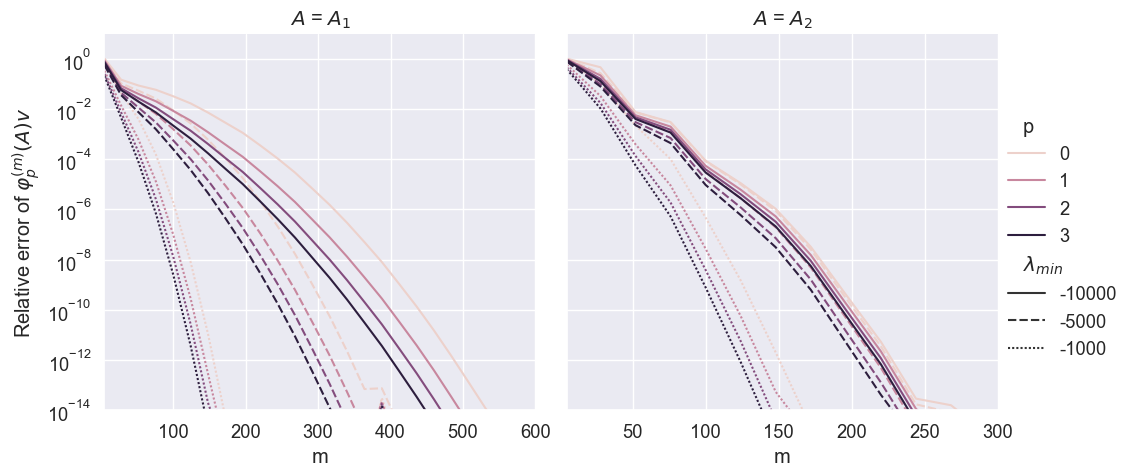

In [60]:
data = df[
    # phi functions
    (df['p'] != 4)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda_{min}$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);
fg.axes[0].set(xlim=[5, 600]);
fg.axes[1].set(xlim=[5, 300]);

## Convergence for different matrices

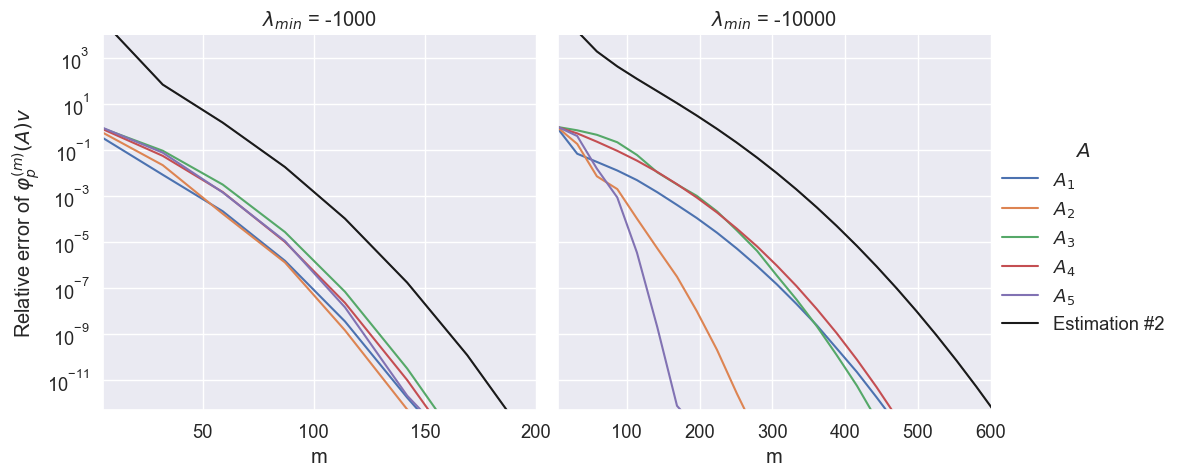

In [53]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    # & ((df['n'] == 2500) | (df['n'] == 3600))
    & ((df['n'] == 4900))

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda_{min}$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'Estimation #2'],
    col_order=[-1000, -10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'k'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[5e-13, 1e+04],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different methods

[(5.0, 250.0)]

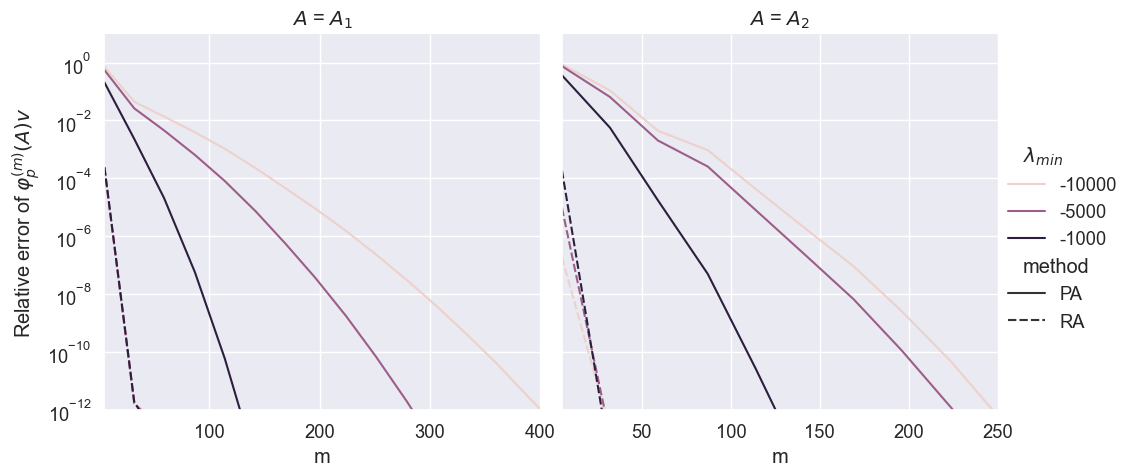

In [55]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    # & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 4900)

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='$\\lambda_{min}$',
    col='$A$',
    style='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
)
fg.axes[0].set(xlim=[5, 400])
fg.axes[1].set(xlim=[5, 250])

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

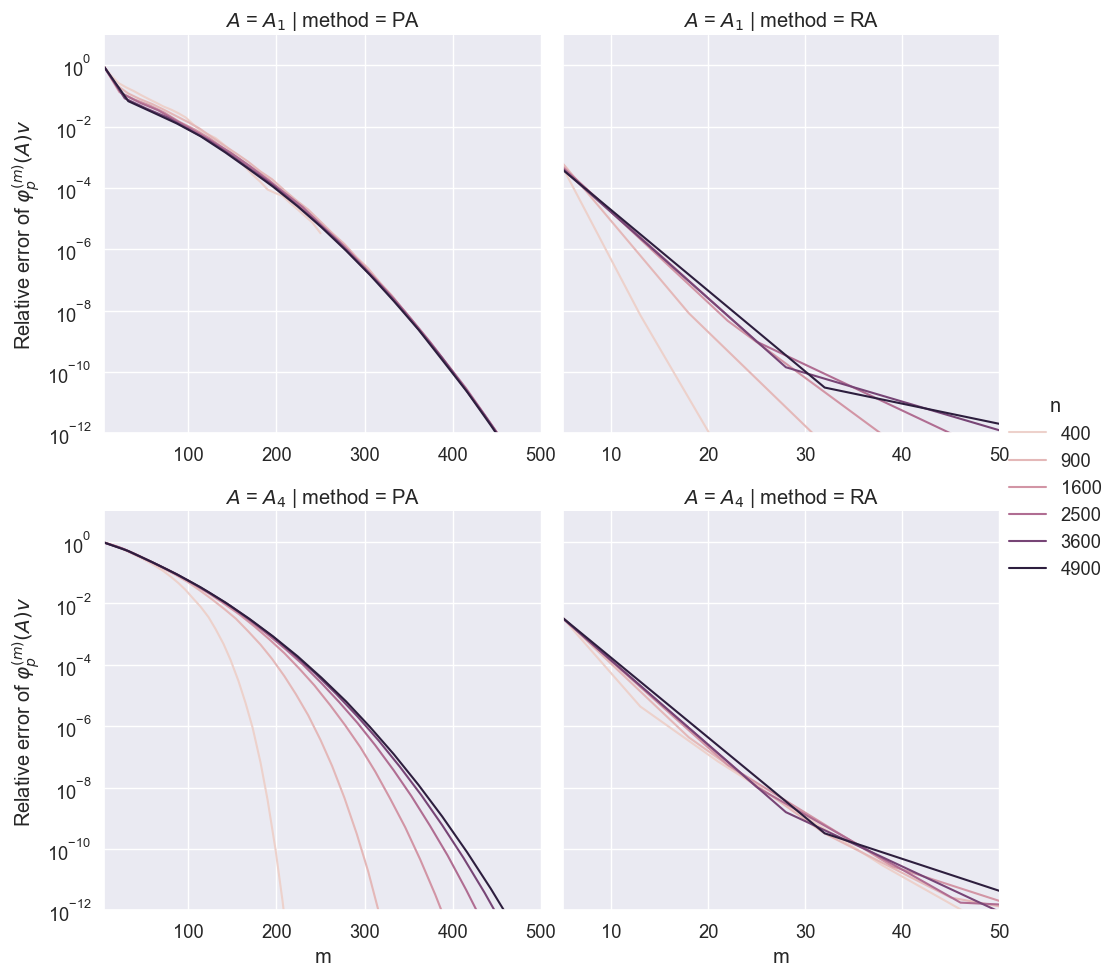

In [47]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    # & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_4$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == -10000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='n',
    col='method',
    row='$A$',
    # style='method',
    # col_wrap=2,
    facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
)
fg.axes[0, 0].set(xlim=[5, 500]);
fg.axes[0, 1].set(xlim=[5, 50]);
fg.axes[1, 0].set(xlim=[5, 500]);
fg.axes[1, 1].set(xlim=[5, 50]);